In [2]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
#from NYT_data_collect import saveFilePath



In [3]:
file_path = '../../Resources/NYT_counties_data.csv'
NYT_df = pd.read_csv(file_path)
file_path = '../../Resources/UnemploymentUSA.csv'
unemployment_df = pd.read_csv(file_path)
NYT_df.head()

,Unnamed: 0,date,county,state,fips,cases,deaths
0,0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,3,2020-01-24,Cook,Illinois,17031.0,1,0
4,4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [4]:
deathSumCounty_df = NYT_df.groupby("county").sum()
deathSumCounty_df.head()

,Unnamed: 0,fips,cases,deaths
county,,,,
Abbeville,532635,1035023.0,91,0
Acadia,498654,440020.0,835,25
Accomack,533823,1122022.0,128,0
Ada,524916,464029.0,4777,47
Adair,1742818,1832067.0,373,11


In [5]:
unemployment_df.head()

,FIPS,State,Area_name,Rural_urban_continuum_code_2013,Urban_influence_code_2013,Metro_2013,Civilian_labor_force_2007,Employed_2007,Unemployed_2007,Unemployment_rate_2007,...,Civilian_labor_force_2017,Employed_2017,Unemployed_2017,Unemployment_rate_2017,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2018,Med_HH_Income_Percent_of_State_Total_2018
0,0,US,United States,NaN,NaN,NaN,"152,191,093","145,156,134","7,034,959",4.6,...,"160,273,906","153,293,830","6,980,076",4.4,"161,640,488","155,344,043","6,296,445",3.9,"$61,937",NaN
1,1000,AL,Alabama,NaN,NaN,NaN,"2,175,612","2,089,127","86,485",4.0,...,2178243,2081676,96567,4.4,"2,198,837","2,112,347","86,490",3.9,"$49,881",100.0
2,1001,AL,"Autauga County, AL",2.0,2.0,1.0,"24,383","23,577",806,3.3,...,25972,24958,1014,3.9,"25,957","25,015",942,3.6,"$59,338",119.0
3,1003,AL,"Baldwin County, AL",3.0,2.0,1.0,"82,659","80,099","2,560",3.1,...,92090,88342,3748,4.1,"93,849","90,456","3,393",3.6,"$57,588",115.5
4,1005,AL,"Barbour County, AL",6.0,6.0,0.0,"10,334","9,684",650,6.3,...,8317,7831,486,5.8,"8,373","7,940",433,5.2,"$34,382",68.9


In [6]:
def getCounty(area_name):
    sub_str = area_name.split(", ")
    if len(sub_str) > 1:
        return sub_str[0].replace(" County","")
    else:
        return "not_county"

In [7]:
unemployment_df["county"] = unemployment_df["Area_name"].map(getCounty)
unemployment_df.dropna(inplace = True)
#unemployment_df["County_name"].head()
unemployment_df.head(1)

,FIPS,State,Area_name,Rural_urban_continuum_code_2013,Urban_influence_code_2013,Metro_2013,Civilian_labor_force_2007,Employed_2007,Unemployed_2007,Unemployment_rate_2007,...,Employed_2017,Unemployed_2017,Unemployment_rate_2017,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2018,Med_HH_Income_Percent_of_State_Total_2018,county
2,1001,AL,"Autauga County, AL",2.0,2.0,1.0,"24,383","23,577",806,3.3,...,24958,1014,3.9,"25,957","25,015",942,3.6,"$59,338",119.0,Autauga


In [8]:
NYT_df.county.value_counts()

Washington    622
Unknown       594
Jefferson     471
Franklin      430
Jackson       383
             ... 
Miner           1
Washita         1
Pacific         1
Benzie          1
Sargent         1
Name: county, Length: 1582, dtype: int64

In [9]:
merged_df = pd.merge(deathSumCounty_df,unemployment_df,on="county")
merged_df.head()

,county,Unnamed: 0,fips,cases,deaths,FIPS,State,Area_name,Rural_urban_continuum_code_2013,Urban_influence_code_2013,...,Civilian_labor_force_2017,Employed_2017,Unemployed_2017,Unemployment_rate_2017,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2018,Med_HH_Income_Percent_of_State_Total_2018
0,Abbeville,532635,1035023.0,91,0,45001,SC,"Abbeville County, SC",6.0,5.0,...,9949,9491,458,4.6,"10,058","9,658",400,4.0,"$42,412",80.9
1,Accomack,533823,1122022.0,128,0,51001,VA,"Accomack County, VA",8.0,6.0,...,16622,15870,752,4.5,"16,762","16,123",639,3.8,"$42,879",59.1
2,Ada,524916,464029.0,4777,47,16001,ID,"Ada County, ID",2.0,2.0,...,234620,227974,6646,2.8,"244,525","238,510","6,015",2.5,"$66,827",120.4
3,Adair,1742818,1832067.0,373,11,19001,IA,"Adair County, IA",8.0,7.0,...,4128,4013,115,2.8,"4,116","4,018",98,2.4,"$54,282",90.4
4,Adair,1742818,1832067.0,373,11,21001,KY,"Adair County, KY",7.0,9.0,...,7171,6736,435,6.1,"7,246","6,879",367,5.1,"$37,392",74.5


In [10]:
sample_df = merged_df.sample(100)

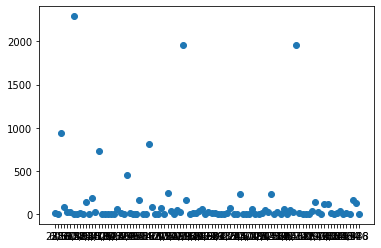

In [11]:
plt.scatter(x=sample_df["Unemployed_2018"],y=sample_df["deaths"])